We'll be working with a CSV file containing movie reviews. Each row contains the text of the review, as well as a number indicating whether the tone of the review is positive(1) or negative(-1).

We want to predict whether a review is negative or positive, based on the text alone. To do this, we'll train an algorithm using the reviews and classifications in train.csv, and then make predictions on the reviews in test.csv. We'll be able to calculate our error using the actual classifications in test.csv to see how good our predictions were.

We'll use [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) for our classification algorithm. A Naive Bayes classifier works by figuring out how likely data attributes are to be associated with a certain class.

This classifier is based on [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) which is,

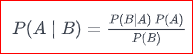

This equation basically states that "the probability of A given that B is true equals the probability of B given that A is true times the probability of A being true, divided by the probability of B being true."

In [1]:
# Let's say this is our running history for the past week

days = [["ran", "was tired"], ["ran", "was not tired"], ["didn't run", "was tired"], ["ran", "was tired"], 
        ["didn't run", "was not tired"], ["ran", "was not tired"], ["ran", "was tired"]]


In [58]:
prob_tired = len([d for d in days if d[1] == "was tired"]) / len(days)

prob_ran = len([d for d in days if d[0] == "ran"]) / len(days)

prob_ran_given_tired = len([d for d in days if d[0] == "ran" and d[1] == "was tired"]) /len([d for d in days if d[1] == "was tired"])

In [4]:
# Now we can calculate P(A|B)
prob_tired_given_ran = (prob_ran_given_tired * prob_tired) / prob_ran

print("Probability of being tired given that you ran: {0}".format(prob_tired_given_ran))

Probability of being tired given that you ran: 0.6


Let's try a slightly different example. Let's say we still have one classification -- whether or not we were tired. And let's say we have two data points -- whether or not we ran, and whether or not we woke up early. Bayes' theorem doesn't work in this case, because we have two data points, instead of just one.

This is where Naive Bayes can help. Naive Bayes extends Bayes' theorem to handle this case by assuming that each data point is independent.

The formula looks like this:

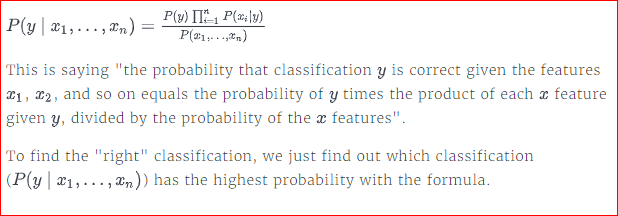

In [5]:
# Here's our data, but with "woke up early" or "didn't wake up early" added
days = [["ran", "was tired", "woke up early"], ["ran", "was not tired", "didn't wake up early"],
        ["didn't run", "was tired", "woke up early"], ["ran", "was tired", "didn't wake up early"], 
        ["didn't run", "was tired", "woke up early"], ["ran", "was not tired", "didn't wake up early"],
        ["ran", "was tired", "woke up early"]]

In [6]:
# We're trying to predict whether or not you were tired on this day
new_day = ["ran", "didn't wake up early"]

In [59]:
def calc_y_probability(y_label, days):
    return len([d for d in days if d[1] == y_label]) / len(days)

def calc_ran_probability_given_y(ran_label, y_label, days):
    return len([d for d in days if d[1] == y_label and d[0] == ran_label]) / len(days)

def calc_woke_early_probability_given_y(woke_label, y_label, days):
    return len([d for d in days if d[1] == y_label and d[2] == woke_label]) / len([d for d in days if d[1] == y_label])

denominator = len([d for d in days if d[0] == new_day[0] and d[2] == new_day[1]]) / len(days)

In [60]:
prob_tired = (calc_y_probability("was tired", days) * calc_ran_probability_given_y(new_day[0], "was tired", days) * calc_woke_early_probability_given_y(new_day[1], "was tired", days)) / denominator

prob_not_tired = (calc_y_probability("was not tired", days) * calc_ran_probability_given_y(new_day[0], "was not tired", days) * calc_woke_early_probability_given_y(new_day[1], "was not tired", days)) / denominator

In [61]:
# Make a classification decision based on the probabilities
classification = "was tired"
if prob_not_tired > prob_tired:
    classification = "was not tired"
print("Final classification for new day: {0}. Tired probability: {1}. Not tired probability: {2}.".format(classification, prob_tired, prob_not_tired))

Final classification for new day: was not tired. Tired probability: 0.14285714285714288. Not tired probability: 0.19047619047619047.


We're trying to determine if we should classify a data row as negative or positive. Because of this, we can ignore the denominator.

We have to calculate the probabilities of each classification, and the probabilities of each feature falling into each classification.

In the above example, we were working with several discrete features. Here, all we have is one long string, but we can generate features from it. The easiest way to generate features from text is to split the text up into words. Each word in a movie review will then be a feature that we can work with. To do this, we'll split the reviews based on whitespace.

Afterwards, we'll count up how many times each word occurs in the negative reviews, and how many times each word occurs in the positive reviews. Eventually, we'll use the counts to compute the probability that a new review will belong to one class versus the other.

In [10]:
# A nice Python class that lets us count how many times items occur in a list
from collections import Counter
import csv
import re

In [11]:
# Read in the training data
with open("train.csv", 'r') as file:
    reviews = list(csv.reader(file))

In [21]:
def get_text(reviews, score):
    # Join together the text in the reviews for a particular tone
    # Lowercase the text so that the algorithm doesn't see "Not" and "not" as different words, for example
    return " ".join([r[0].lower() for r in reviews if r[1] == str(score)])

In [34]:
def count_text(text):
    # Split text into words based on whitespace -- simple but effective
    words = re.split("\s+", text)
    # Count up the occurrence of each word
    return Counter(words)


In [35]:
negative_text = get_text(reviews, -1)
positive_text = get_text(reviews, 1)

In [36]:
# Generate word counts for negative tone
negative_counts = count_text(negative_text)
# Generate word counts for positive tone
positive_counts = count_text(positive_text)

In [38]:
print("Negative text sample: {0}".format(negative_text[:100]))
print("Positive text sample: {0}".format(positive_text[:100]))

Negative text sample: plot : two teen couples go to a church party drink and then drive . they get into an accident . one 
Positive text sample: films adapted from comic books have had plenty of success whether they're about superheroes ( batman


Now that we have the word counts, we just need to convert them to probabilities and multiply them out to predict the classifications.

Let's say we wanted to find the probability that the review **didn't like it** expresses a negative sentiment. We would find the total number of times the word **didn't** occurred in the negative reviews, and divide it by the total number of words in the negative reviews to get the probability of x given y. We would then do the same for like and it. We would multiply all three probabilities, and then multiply by the probability of any document expressing a negative sentiment to get our final probability that the sentence expresses negative sentiment.

We would do the same for positive sentiment. Then, whichever probability is greater would be the class that the algorithm assigns the review to.

In [39]:
def get_y_count(score):
    # Compute the count of each classification occurring in the data
    return len([r for r in reviews if r[1] == str(score)])

In [41]:
# We'll use these counts for smoothing when computing the prediction
positive_review_count = get_y_count(1)
negative_review_count = get_y_count(-1)

# These are the class probabilities (we saw them in the formula as P(y))
prob_positive = positive_review_count / len(reviews)
prob_negative = negative_review_count / len(reviews)

In [45]:
def make_class_prediction(text, counts, class_prob, class_count):
    prediction = 1
    text_counts = Counter(re.split("\s+", text))
    for word in text_counts:
        # For every word in the text, we get the number of times that word occurred in the reviews for a given class, add 1 to smooth the value, and divide by the total number of words in the class (plus the class_count, also to smooth the denominator)
        # Smoothing ensures that we don't multiply the prediction by 0 if the word didn't exist in the training data
        # We also smooth the denominator counts to keep things even
        prediction *=  text_counts.get(word) * ((counts.get(word, 0) + 1) / (sum(counts.values()) + class_count)) # +1 showing additive smoothing
    # Now we multiply by the probability of the class existing in the documents
    return prediction * class_prob


In [43]:
# Now we can generate probabilities for the classes our reviews belong to
# The probabilities themselves aren't very useful -- we make our classification decision based on which value is greater
print("Review: {0}".format(reviews[0][0]))
print("Negative prediction: {0}".format(make_class_prediction(reviews[0][0], negative_counts, prob_negative, negative_review_count)))
print("Positive prediction: {0}".format(make_class_prediction(reviews[0][0], positive_counts, prob_positive, positive_review_count)))

Review: plot : two teen couples go to a church party drink and then drive . they get into an accident . one of the guys dies but his girlfriend continues to see him in her life and has nightmares . what's the deal ? watch the movie and " sorta " find out . . . critique : a mind-fuck movie for the teen generation that touches on a very cool idea but presents it in a very bad package . which is what makes this review an even harder one to write since i generally applaud films which attempt
Negative prediction: 3.005053036235652e-221
Positive prediction: 1.307170546690679e-226


Now that we can make predictions, let's predict the probabilities for the reviews in test.csv. We'll get misleadingly good results if we predict on the reviews in train.csv, because we used that data set to generate the probabilities in the first place (so the algorithm has prior knowledge about the data it's predicting on).

Getting good results on the training set could mean that our model is [overfit](http://en.wikipedia.org/wiki/Overfitting), and just picking up random noise. Testing on a set the model wasn't trained with is the only way to tell if it's performing properly.

In [46]:
def make_decision(text, make_class_prediction):
    # Compute the negative and positive probabilities
    negative_prediction = make_class_prediction(text, negative_counts, prob_negative, negative_review_count)
    positive_prediction = make_class_prediction(text, positive_counts, prob_positive, positive_review_count)

    # We assign a classification based on which probability is greater
    if negative_prediction > positive_prediction:
      return -1
    return 1

with open("test.csv", 'r') as file:
    test = list(csv.reader(file))

predictions = [make_decision(r[0], make_class_prediction) for r in test]

Now that we know the predictions, we'll compute error using the area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve). This will tell us how "good" the model is; closer to 1 means that the model is better.

Computing error is a very important measure of whether your model is "good," and when it's getting better or worse.

In [47]:
actual = [int(r[1]) for r in test]

from sklearn import metrics

# Generate the ROC curve using scikits-learn
fpr, tpr, thresholds = metrics.roc_curve(actual, predictions, pos_label=1)

# Measure the area under the curve
# The closer to 1 it is, the "better" the predictions
print("AUC of the predictions: {0}".format(metrics.auc(fpr, tpr)))

AUC of the predictions: 0.680701754385965


There are a lot of extensions we could add to this algorithm to make it perform better. We could look at [n-grams](https://en.wikipedia.org/wiki/N-gram) instead of unigrams, for example. We could also remove punctuation and other non-characters. We could remove [stopwords](http://en.wikipedia.org/wiki/Stop_words), or perform [stemming](https://en.wikipedia.org/wiki/Stemming) or lemmatization.

We don't want to have to code the entire algorithm out every time, though. An easier way to use Naive Bayes is to use the implementation in scikit-learn. [Scikit-learn](http://scikit-learn.org/stable/) is a Python machine learning library that contains implementations of all the common machine learning algorithms.

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [55]:
# Generate counts from text using a vectorizer  
# We can choose from other available vectorizers, and set many different options
# This code performs our step of computing word counts
vectorizer = CountVectorizer(stop_words='english', max_df=.05)
train_features = vectorizer.fit_transform([r[0] for r in reviews])
test_features = vectorizer.transform([r[0] for r in test])

In [56]:
# Fit a Naive Bayes model to the training data
# This will train the model using the word counts we computed and the existing classifications in the training set
nb = MultinomialNB()
nb.fit(train_features, [int(r[1]) for r in reviews])

# Now we can use the model to predict classifications for our test features
predictions = nb.predict(test_features)

In [57]:
# Compute the error
# It's slightly different from our model because the internals of this process work differently from our implementation
fpr, tpr, thresholds = metrics.roc_curve(actual, predictions, pos_label=1)
print("Multinomal naive bayes AUC: {0}".format(metrics.auc(fpr, tpr)))

Multinomal naive bayes AUC: 0.635500515995872
